### DATA 620
#### Project 2   
### [Video Presentation]()
##### Group Four
- Santosh Cheruku
- Vinicio Haro
- Javern Wilson
- Saayed Alam  

In [65]:
# load libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
from networkx.algorithms import bipartite as bi
from collections import Counter

In this assignment, we are asked to identify a large 2-node network dataset. The data meets the criteria that it consists of ties between and not within two (or more) distinct groups. In our case the ties are between actors and movies. More precisely, an edge represents an appearance by an actor in a movie. There are no ties between actors nor movies. 

In [66]:
# load dataset
appear = pd.read_csv("https://raw.githubusercontent.com/san123i/CUNY/master/Semester2/620-WebAnalytics/Week4/data/out.actor-movie",
                  header = None, skiprows = 1, sep = " ").rename(columns = {0: "movie", 1: "actor", 2: "appearance"})

### Dataset
This is a bipartite network of movies and the actors that have played in them. Since the dataset has more than a million edges, we will first sample only 2% of the dataset. We also built a weight variable which is the number of appearances an actor has made in movies. The more appearances an actor has, the more experience he has. 

In [67]:
# create a new variable of weight
appear['appearance'] = appear.groupby(['actor',]).actor.transform('count')

# sample 2% of the dataset
appear = appear.sample(frac = 0.2, random_state = 123)
appear.head()

,movie,actor,appearance
909646,78484,204526,1
1280049,106724,313982,1
1002850,85837,232282,1
843543,73327,159820,8
584507,51985,72752,28


In [68]:
# create a graph
B = nx.Graph()

# add nodes with the node attribute "bipartite"
B.add_nodes_from(list(appear.movie.values), bipartite=0)
B.add_nodes_from(list(appear.actor.values), bipartite=1)

# add edges only between nodes of opposite node sets with weights
subset = appear[['movie', 'actor', 'appearance']]
edges_tuples = [tuple(x) for x in subset.values]
B.add_weighted_edges_from(edges_tuples)

In [69]:
# print graph info
print(nx.info(B))

Name: 
Type: Graph
Number of nodes: 183169
Number of edges: 294081
Average degree:   3.2110


### Data Preparation
We reduce the size of the network by island method. The island method works as follows: imagine our network as an island with a complex terrain, where the height of each point on the terrain is defined by the value of a node (number of appearances). Now let us imagine that the water level around this island is rising slowly, leaving portions of the landscape underwater. When the valleys in the island are flooded, the island essentially splits into smaller islands—revealing where the highest peaks are, and making these peaks smaller. In our case, the water level will reveal highest number of appearances

In [70]:
# trim edges function from the book 
def trim_edges(g, weight = 1):
    edges = []
    g2 = nx.Graph()
    for f, to, edata in g.edges(data = True):
        if edata['weight'] > weight:
            x = float(edata['weight'])
            edges.append((f, to, x))
    g2.add_weighted_edges_from(edges)
    return g2

# island method function from the book 
def island_method(g, iterations = 5):
    weights = [edata['weight'] for f, to, edata in g.edges(data = True)]
    mn = int(min(weights))
    mx = int(max(weights))
    step = int((mx - mn) / iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn, mx, step)]

Let us examine the threshold table. For instance, threshold 4 represents 517 appearances. This could be background actors or actors will multiple appearances in a movie. A visualization of the graph would clear some assumptions. It seems like a movie or two movies had 132 apperances. 

In [71]:
# display thresholds
values = [['Threshold', 'Appearances']]
islands = island_method(B, iterations = 5)

for i in islands:
    threshold = i[0]
    num_people = len(i[1])
    temp_list = [threshold, num_people]
    values.append(temp_list)
    
headers = values.pop(0)
islan_df = pd.DataFrame(values, columns = headers)
islan_df

,Threshold,Appearances
0,1,138792
1,130,11016
2,259,1458
3,388,654
4,517,132


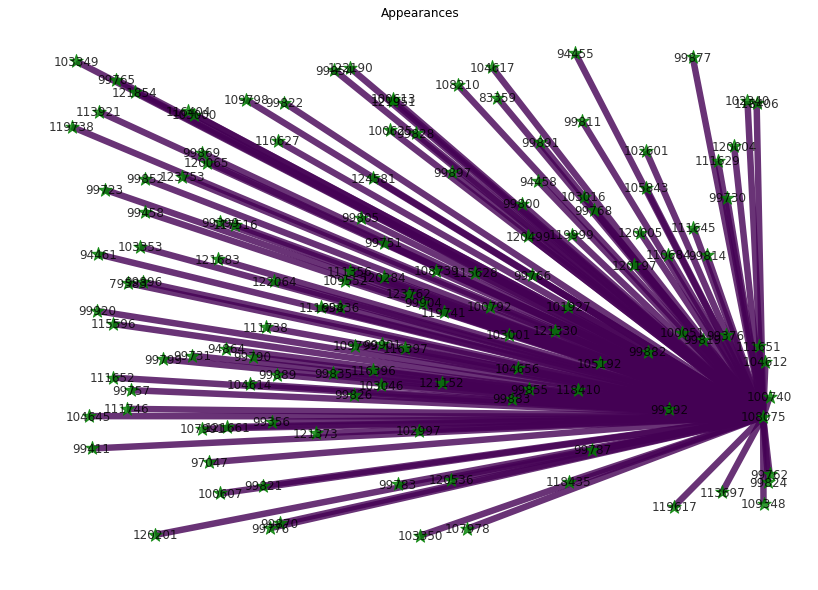

In [72]:
plt.figure(figsize = (14, 10))

# trim edges
island_plot = trim_edges(B, 517)
weights = [math.log(edata['weight']) for f, t, edata in island_plot.edges(data=True)]

# draw threshold 
sp = nx.random_layout(island_plot)
nx.draw_networkx(island_plot, sp, width = weights, edge_color = weights, node_size = 200,
                node_shape = "*", node_color = "green", alpha = 0.8)
plt.axis('off')
plt.title("Appearances")
plt.show()

### Inference
What can we infer about each of the distinct groups? Since, our graph is undirected, we cannot extract component subgraphs but we can infer other information. 

#### Movie Network
Let us look at the movie group first.  It is clear that the network has a number of distinct clusters; we find them using the island method and visualize the graph. The resulting network graph of threshold 4 highlights strength of relationships using color and edge thickness. We can tell by the edge between the movies that there is a strong relationship. It means both movies have high number of appearances by the same actors. 

In [73]:
# movie network 
movie_graph = bi.weighted_projected_graph(B, appear.movie, ratio = False)

In [74]:
# display thresholds
values = [['Threshold', 'Connection between Movies']]
islands = island_method(movie_graph, iterations = 5)

for i in islands:
    threshold = i[0]
    num_people = len(i[1])
    temp_list = [threshold, num_people]
    values.append(temp_list)
    
headers = values.pop(0)
islan_df = pd.DataFrame(values, columns = headers)
islan_df

,Threshold,Connection between Movies
0,1,11552
1,2,695
2,3,99
3,4,22
4,5,7
5,6,4
6,7,4


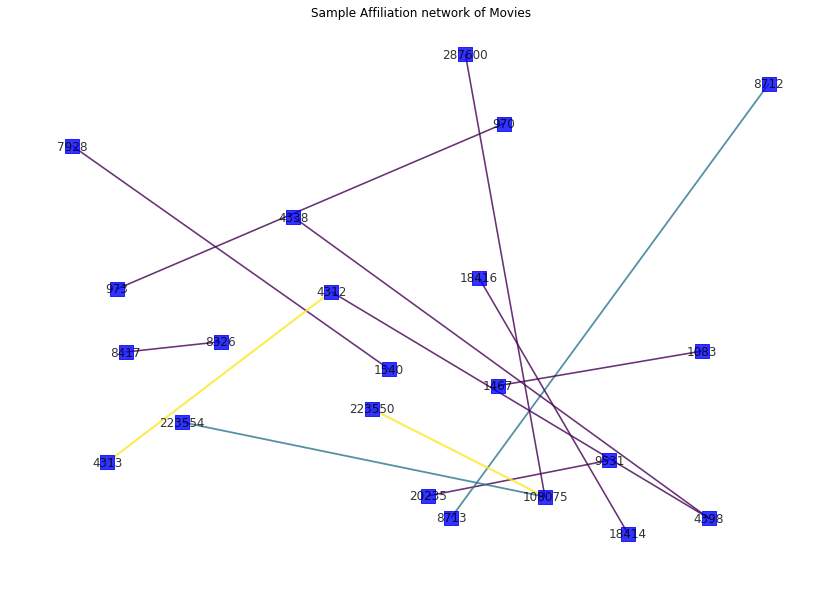

In [75]:
plt.figure(figsize = (14, 10))

# trim edges
movie_island = trim_edges(movie_graph, 4)
weights = [math.log(edata['weight']) for f, t, edata in movie_island.edges(data=True)]

# draw threshold 
sp = nx.random_layout(movie_island)
nx.draw_networkx(movie_island, sp, width = weights, edge_color = weights, node_size = 200,
                node_shape = "s", alpha = 0.8, node_color = "blue")
plt.axis('off')
plt.title("Sample Affiliation network of Movies")
plt.show()

For finding very connected movies, popular movies who are likely to hold most information or actors who can quickly connect with the wider network, we use degree centrality. The movie with most connection from above graph has 3 connections i.e.  number of appearances by the same actors. Also, we graph the edge weight of movies and see that the majority of the movies do not have that many appearances by actors. It could be because majority of the movies do not have that many starring roles. 

In [76]:
# degree centrality
max(dict(movie_island.degree()).keys())
deg = movie_island.degree()

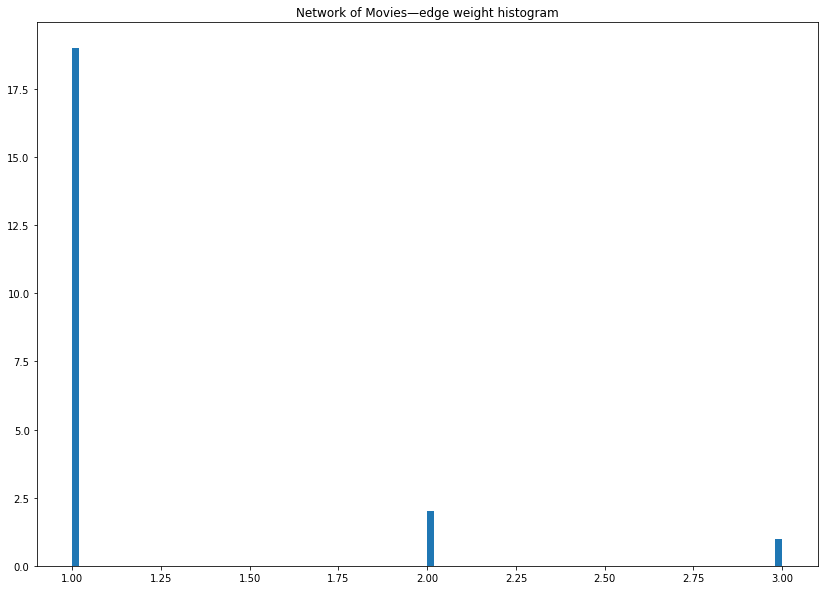

In [77]:
plt.figure(figsize = (14, 10))

# visualize degree centrality
plt.hist(dict(deg).values(), 100) 
plt.title("Network of Movies—edge weight histogram")
plt.show()

#### Actor Graph
Lastly, we will look at the actor network. The weighted projected graph is the projection of the bipartite network B onto the actor nodes with weights representing the number of appearances. From the threshold table, we can tell that the count of connection is quite similar to the connection between movies. In this particular dataset, that makes sense because actors build network by being in the same movie. The more appearances they have together, the stronger their network will be. 

In [78]:
# actor network
actor_graph = bi.weighted_projected_graph(B, appear.actor, ratio = False)

In [79]:
# display thresholds
values = [['Threshold', 'Connection between Actors']]
islands = island_method(actor_graph, iterations = 5)

for i in islands:
    threshold = i[0]
    num_people = len(i[1])
    temp_list = [threshold, num_people]
    values.append(temp_list)
    
headers = values.pop(0)
islan_df = pd.DataFrame(values, columns = headers)
islan_df

,Threshold,Connection between Actors
0,1,10976
1,2,692
2,3,115
3,4,29
4,5,12
5,6,5
6,7,4


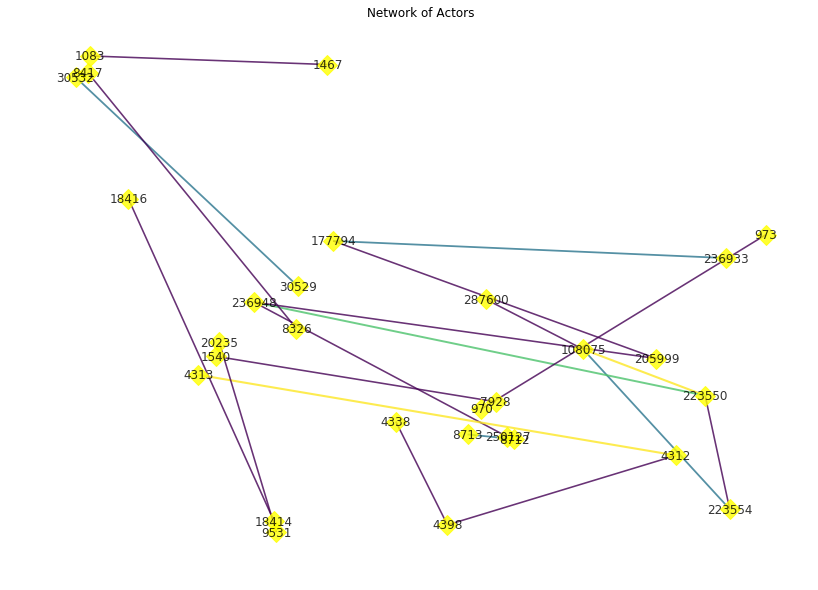

In [80]:
plt.figure(figsize = (14, 10))

# trim edges
actor_island = trim_edges(actor_graph, 4)
weights = [math.log(edata['weight']) for f, t, edata in actor_island.edges(data=True)]

# draw threshold 
sp = nx.random_layout(actor_island)
nx.draw_networkx(actor_island, sp, width = weights, edge_color = weights, node_size = 200,
                node_shape = "D", alpha = 0.8, node_color = "yellow")
plt.axis('off')
plt.title("Network of Actors")
plt.show()

In [81]:
# degree centrality
max(dict(actor_island.degree()).keys())

287600

### Conclusion
From our undirected bipartite graph, we were able to infer several informations. We found the movie that has the most appearances. We were also able to find the movies that have high number of appearances and the actors with the most appearance. In general, what we learned from the dataset is the more appearances the same actors have in a network of movies, the wider their influence will become. This is a perfect example of the Marvel Cinematic Universe. 